Source: [part 3](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb)

In [3]:
import os
from IPython.display import Image 

pth = os.getcwd()
pth

'/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/NLPstudy'

# 3 - Neural Machine Translation by Jointly Learning to Align and Translate

In this third notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from: 

- [Paper - Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)

This model achives our best perplexity yet, ~27 compared to ~34 for the previous model.



## Introduction

As a reminder, here is the general encoder-decoder model:

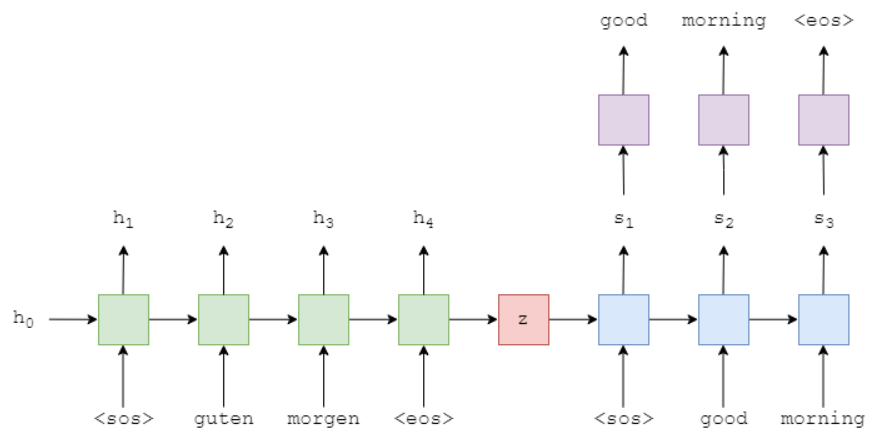

In [4]:
Image(filename = pth + "/images/rnn_translation.png")

In the previous model (sequence to sequence GRU), our architecture was set-up in a way to reduce "information compression" by explicitly passing the context vector, $z$, to the decoder at every time-step and by passing both the context vector and input word, $y_t$, along with the hidden state, $s_t$, to the linear layer, $f$, to make a prediction.


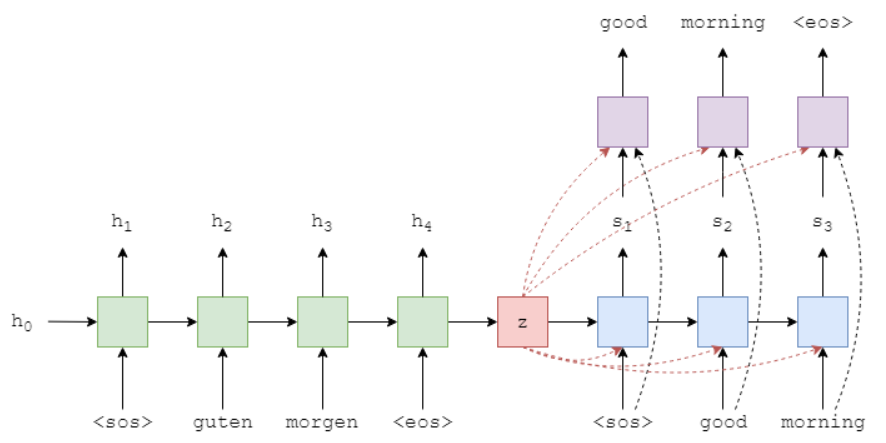

In [6]:
Image(filename = pth + "/images/seq2seqGRU.png")

Even though we have reduced some of this compression, our context vector still needs to contain all of the information about the source sentence. The model implemented in this notebook avoids this compression by allowing the decoder to look at the entire source sentence (via its hidden states) at each decoding step! How does it do this? It uses *attention*. \
 \
    Attention works by first, calculating an attention vector, $a$, that is the length of the source sentence. The attention vector has the property that each element is between 0 and 1, and the entire vector sums to 1. We then calculate a weighted sum of our source sentence hidden states, $H$, to get a weighted source vector, $w$. \
 \
    $$w = \sum_{i}a_ih_i$$

We calculate a new weighted source vector every time-step when decoding, using it as input to our decoder RNN as well as the linear layer to make a prediction. We'll explain how to do all of this during the tutorial.

## Preparing Data

Again, the preparation is similar to last time.

First we import all the required modules.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.tensor as Tensor

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

In [10]:
# Set random seeds for reproducibility

SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### 1. Create the Tokenizers

Next, we'll create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"].

spaCy has model for each language ("de" for German and "en" for English) which need to be loaded so we can access the tokenizer of each model.

In [11]:
# Download the spacy models via command line:
# conda activate pynlp_env
# cd /development/.../NLPStudy/data
# python -m spacy download en
# python -m spacy download de

# Then load the models
spacyDE = spacy.load('de')
spacyEN = spacy.load('en')

### 2. Create the Tokenizer Functions

Next, we create the tokenizer functions. These can be passed to TorchText and will take in the sentence as a string and return the sentence as a list of tokens.

In [12]:
# Creating the tokenizer functions
# NOTE: not reversing source (German) anymore.

def tokenizeGerman(germanText: str):
    """
    Tokenizes German text from a string into a list of strings (as tokens)
    :param germanText: 
    :return: 
    """
    return [tok.text for tok in spacyDE.tokenizer(germanText)]

def tokenizeEnglish(englishText: str):
    """
    Tokenizes English text from a string into a list of strings (as tokens)
    and reverses it
    
    :param englishText: 
    :return: 
    """
    return [tok.text for tok in spacyEN.tokenizer(englishText)]

We set the tokenize argument to the correct tokenization function for each, with German being the `SRC` (source) field and English being the `TRG` (target) field. The `Field` also appends the "start of sequence" and "end of sequence" tokens via the `init_token` and `eos_token` arguments, and converts all words to lowercase.

[To read more about Field's arguments](https://github.com/pytorch/text/blob/master/torchtext/data/field.py#L61)


In [13]:
# German = source language, English = target language

# tokenize:  The function used to tokenize strings using this field into
#             sequential examples.
# init_token: A token that will be prepended to every example using this
#             field, or None for no initial token. Default: None.
# eos_token: A token that will be appended to every example using this
#             field, or None for no end-of-sentence token. Default: None.
# lower: Whether to lowercase the text in this field. Default: False.
SRC = Field(tokenize = tokenizeGerman,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

TRG = Field(tokenize = tokenizeEnglish,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

### 3. Download the Data

Next, we download and load the train, validation and test data.

The dataset we'll be using is the [Multi30k dataset](https://github.com/multi30k/dataset).
This is a dataset with ~30,000 parallel English, German and French sentences, each with ~12 words per sentence.

In [14]:
# `exts` : specifies which languages to use as the source and target
# (source goes first) 
# `fields`: specifies which field to use for the source and target.

# NOTE: after this, the data is stored in 
# a folder under NLPSTUDY called '.data'
trainData, validationData, testData = Multi30k.splits(exts = ('.de', '.en'),
                                                      fields = (SRC, TRG))

In [15]:
# Print out examples to verify the source (German) is not reversed ...

# Double-checking we have the right number of examples: 
print(f"Number of training examples: {len(trainData.examples)}")
print(f"Number of validation examples: {len(validationData.examples)}")
print(f"Number of testing examples: {len(testData.examples)}")

print("\n")

# Printing out an example to make sure the source sentence is
# not reversed (if you know German); the target (english) is in proper order, though. 
print(trainData.examples[0])
print(vars(trainData.examples[0]))

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


### 4. Building the vocabulary

Next, we build the *vocabulary* for the source and target languages.

The vocabulary is used to associate each unique token (word) with an index (an integer), similar to the way a dictionary works.

This is used to build a one-hot encoding for each token (a vector of all zeros except for the position represented by the index, which is 1).

The vocabularies of the source and target languages are distinct.

Using the `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token.

WARNING: It is important to note that your vocabulary should only be built from the training set and not the validation/test set. This prevents "information leakage" into your model, giving you artifically inflated validation/test scores.

In [16]:
SRC.build_vocab(trainData, min_freq=2)
TRG.build_vocab(trainData, min_freq=2)

In [18]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


### 5. (Final) Create the Iterators

The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have a `src` attribute (the PyTorch tensors containing a batch of numericalized source sentences) and a `trg` attribute (the PyTorch tensors containing a batch of numericalized target sentences). Numericalized is just a fancy way of saying they have been converted from a sequence of readable tokens to a sequence of corresponding indexes, using the vocabulary.

We also need to define a `torch.device`. This is used to tell TorchText to put the tensors on the GPU or not. We use the `torch.cuda.is_available()` function, which will return `True` if a GPU is detected on our computer. We pass this `device` to the iterator.

When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, TorchText iterators handle this for us!

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [20]:
# Creating the training iterator

BATCH_SIZE = 128

trainIterator, validationIterator, testIterator = BucketIterator.splits(
    (trainData, validationData, testData),
    batch_size = BATCH_SIZE,
    device = device)

## Building the Seq2Seq Model (GRU)

**Overview:** We use a  bidirectional GRU `Encoder` and non-bidirectional GRU `Decoder`.

#### [GRU Formulation](https://hyp.is/FV-GHhAsEeqa9B_lR5PiZg/pytorch.org/docs/stable/nn.html)

For each element in the input sequence, each layer computes the following functions:

\begin{align*}
r_t &= \text{sigmoid}(W_{ir} x_t + b_{ir} + W_{hr} h_{t-1} + b_{hr}) \\
z_t &= \text{sigmoid}(W_{iz} x_t + b_{iz} + W_{hz} h_{t-1} + b_{hz}) \\
n_t &= \text{tanh}(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{t-1} + b_{hn})) \\
h_t &= (1 - z_t) * n_t + z_t + h_{t-1} \\
\end{align*}

##### Variable Meanings in GRU: 
- $x_t$ = the input at time $t$
- $h_t$ = the hidden state at time $t$
- $h_{t-1}$ = the hidden state of the layer at time $t-1$ or the initial hidden state at time $0$.
- $r_t$ = the reset gate. When the reset gate value is close to $0$, the hidden state is forced to ignore the previous hidden state and reset with the current input only. This allows the hidden state to drop any irrelevant information in the future.
- $z_t$ = the update gate. The update gate controls how much information from the previous hidden state carries to the current hidden state, acting like the memory cell in LSMT, to help remember long-term information.
- $n_t$ = the new gate
- $*$ = the Hadamard product

[**NOTE:**](https://hyp.is/XvhiShAyEeqvoV-jOpBdJw/arxiv.org/pdf/1406.1078.pdf) As each hidden unit has separate reset and update gates, each hidden unit can learn to capture dependencies over different time scales. So now we have a hidden unit that adaptively remembers and forgets, determined by time. 
Those units that learn to capture short-term dependencies will have reset gates that are frequently active, but those that capture longer-term dependencies will have update gates that are mostly active. 

- $W_{ih}$ = tensor containing the learnable input-to-hidden weights of the layers. Has shape (3 * `hiddenSize`, `inputSize`) for $k = 0$, else the shape is (3 * `hiddenSize`, `numDirections` * `hiddenSize`). 
- Refers to: 
	- $W_{ir}$ = input-to-hidden weights for all layers for the reset gate
	- $W_{iz}$ = input-to-hidden weights for all layers for the update gate
	- $W_{in}$ = input-to-hidden weights for all layers for the new gate

- $W_{hh}$ = tensor containing the learnable hidden-to-hidden weights of the layers. Has shape (3 * `hiddenSize`, `hiddenSize`). 
- Refers to: 
	- $W_{hr}$ = hidden-to-hidden weights for all layers for the reset gate
	- $W_{hz}$ = hidden-to-hidden weights for all layers for the update gate
	- $W_{hn}$ = hidden-to-hidden weights for all layers for the new gate


- `inputSize` = the number of expected features in the input $X$
- `hiddenSize` = the number of features in the hidden state $h$
- `numLayers` = number of recurrent layers (setting it to 2 means stacking two GRUs to form a *stacked GRU*). 

##### [Inputs of GRU Model:](https://hyp.is/pBfL1BBNEeqtNBe_R-qBnQ/pytorch.org/docs/stable/nn.html)
- `input` = tensor of shape (`seqLen`, `batchSize`, `inputSize`) that contains the features of the input sequence.
- $h_0$ = tensor of shape (`numLayers` * `numDirections`, `batchSize`, `hiddenSize`) containing the initial hidden state for each element in the batch.

##### [Outputs of GRU Model:](https://hyp.is/srJishBNEeq9gDO7DA-0WQ/pytorch.org/docs/stable/nn.html)
- `output` = tensor of shape (`seqLen`, `batchSize`, `numDirections` * `hiddenSize`) that contains the output features $h_t$ from the last layer of the GRU, for each time step $t$. 
- $h_n$ = `hidden` = tensor of shape (`numLayers` * `numDirections`, `batchSize`, `hiddenSize`) containing the hidden state for $T =$`seqLen`.


The GRU model (drawing) looks like: 

**NOTE:** the $\tilde{h}_t$ represents the new gate, $n_t$

[Image source](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)



### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*. 

- **Bidirectional RNN:** there are two RNNs per layer:
	- A *forward RNN* going over the sentence from left to right (shown below in green), and 
	- a *backward RNN* going over the sentence from right to left (yellow). 

In PyTorch all we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before.

In [ ]:
Image(filename= pth + "/images/3_encoderGRU_bidirectional.png")

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(x_t^\rightarrow,h_t^\rightarrow)\ \
    h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(x_t^\leftarrow,h_t^\leftarrow)
\end{align*}$$

where ... 
- $x_0^\rightarrow = \text{<sos>}
- x_1^\rightarrow = \text{guten}$ and
- $x_0^\leftarrow = \text{<eos>}
- x_1^\leftarrow = \text{morgen}$.



##### [Inputs of Encoder Bi-directional GRU Model:](https://hyp.is/pBfL1BBNEeqtNBe_R-qBnQ/pytorch.org/docs/stable/nn.html)
- `srcEmbedding` = tensor of shape (`seqLen`, `batchSize`, `inputSize`) that contains the features of the input sequence.
	- This tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros.
- $h_0$ = tensor of shape (`numLayers` * `numDirections`, `batchSize`, `hiddenSize`) containing the initial hidden state for each element in the batch.(Defaults to zero if we don't pass it, and we don't pass it)

##### [Outputs of Encoder Bi-directional GRU Model:](https://hyp.is/srJishBNEeq9gDO7DA-0WQ/pytorch.org/docs/stable/nn.html)

- `outputs` = tensor of shape (`srcSentenceLen`, `batchSize`, `numDirections` * `hiddenSize`) that contains the output features $h_t$ from the last layer of the GRU, for each time step $t$. 
	- The first `hiddenDim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hiddenDim` elements are hidden states from the top layer backward RNN. 
	- We can think of the third axis as being the forward and backward hidden states **concatenated** together other: $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ , ..., $h_T = [h_T^\rightarrow; h_1^\leftarrow]$ and we can denote all encoder hidden states (forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

- $h_n$ = `hidden` = tensor of shape (`numLayers` * `numDirections`, `batchSize`, `hiddenSize`) containing the hidden state for $T =$`seqLen`.
	1. **`hidden[-2, :, :]`** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence). 
		- This is called the context vector from the forward RNN: $z^\rightarrow=h_T^\rightarrow$
	2.  **`hidden[-1, :, :]`** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).
		- This is called the context vector from the backward RNN: $z^\leftarrow=h_T^\leftarrow$


**NOTE:** About Combining Context Vectors as Input for `Decoder`: 
As the `Decoder` is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$. 
But we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). 
We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function::
$$
z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0
$$

**WARNING**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so I've changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.